## Hotspots suburbs vs social activities in South Africa's eight (8) Metros for property investment


## 1. Introduction

### 1.1 Description and Discussion of the Background

In south Africa, the constitution provides for three categories of municipalities. There are 278 municipalities in South Africa, comprising of eight metropolitans, 44 district and 226 local municipalities. They are focused on growing local economies and providing infrastructure and service. As a results, the metros contain the hottest cities and suburbs in South Africa with City of Johannesburg, City of Cape Town, City of Tshwane and eThekwini as the four biggest metros containing the hottest suburbs in SA. These metro host cities like Johannesburg, Cape Town, Pretoria and Durban respectively.

As a results we find most SA's residents flocking to these metros from their villages (rural areas) to uncover new treasures like, better education, job opportunities and etc. Eventually, most SA's residents end up residing permanently, buying properties and starting businesses in these cities and thus they become populated. When we think of it from a property investment point of view, we expect investor to buy in areas which are not too populated (for security/safety reasons) and the property value are reasonably low, in addition such area should also have a variety of social places nearby. However, it is not always easy to obtain information that will guide investors in this direction.

Given the problems we have in terms of finding people flocking to the cities to uncover new treasure, we can create a map and information chart where the property value is shown and each hottest suburbs within the eight metros is clustered according to the social venue density and similarities.

These informative maps are not readily available, they can assist people when deciding where to invest in property taking social activities and property values into considerations. They can also assist municipalities (metros in particular) to advance their social development by comparing themselves with the metros in terms of how they compare, where they can improve in order to attract more property investor

### 1.1 Data Description

To consider the problem, we can list the data used and its sources as follow:

- The eight (8) metropolitan's average property value was obtain from the national property report, dated 3 March 2021. Then, this was merged with the hottest suburbs' average property prices within these metros in terms of property investment.
- The average property values were retrieved from property24 and private-property websites.
- Used google earth to obtain the central geographical coordinates of these suburbs in these metros
- **Foursquare API** is used to get the most common venues nearby each of these suburbs up to a radius of 10km, using the central suburbs geographical coordinates obtained from Google maps search engine.

## 2. Methodology

### 2.1 Creating data frame and data pre-processing

#### Importing neccessary libraries

In [1]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd 
import numpy as np 

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import json # library to handle JSON files 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # plotting library
from sklearn.cluster import KMeans # import k-means from clustering stage

#### Building a dataframe of the Metros and their hottest subsurbs

The dataset used here is saved on my GitHub reposity for this study.

In [104]:
#url = r"E:\Desktop\Develpment courses\Programming\IBM Data Science\Notebooks\Applied Data Science Capstone Projects\Final Project\SA_Hottest_Subsurbs.xlsx"
url = "https://github.com/KhumeleniM/SA_Metropolitans_Subsubs/blob/master/SA_Hottest_Subsurbs.xlsx"
col_names = ["Metros", "Suburbs", "Average_Property_Value (Rand)","Latitude","Longitude"]
suburbs = pd.read_excel(url,names=col_names)
suburbs.head()

,Metros,Suburbs,Average_Property_Value (Rand),Latitude,Longitude
0,Buffalo City,East London,635983,-32.924593,27.644027
1,City of Cape Town,Goodwood,1694500,-33.905048,18.566278
2,City of Cape Town,Edgemead,2344500,-33.871335,18.543579
3,City of Cape Town,Kuilsriver,1350000,-33.917228,18.687824
4,City of Cape Town,Southwen Suburbs (Plumstead),2350000,-34.022901,18.475543


In [3]:
suburbs.shape

(34, 5)

#### I use geopy library to get the latitude and longitude values of South Africa

In [4]:
address = 'South Africa'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are -28.8166236, 24.991639.


#### We can create a map of South Africa with hottest suburbs superimposed on top. We use latitude and longitude values to get the visual

In [5]:
map_SA = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng,metro, suburb in zip(suburbs['Latitude'], suburbs['Longitude'],suburbs['Metros'], suburbs['Suburbs']):
    label = '{}, ({})'.format(metro, suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_SA)      
map_SA

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'DTI22PXVDGWZAZI3IDM3HHWJQYQLIJMDYGX3VJZ0NBRB0P3Q' # my Foursquare ID
CLIENT_SECRET = 'YA1UFSQW2FJLAKXQUO5DYFPEHAAIMGRLPTPGT0J4X2MBUIUX' # my Foursquare Secret
VERSION = '20210629' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DTI22PXVDGWZAZI3IDM3HHWJQYQLIJMDYGX3VJZ0NBRB0P3Q
CLIENT_SECRET:YA1UFSQW2FJLAKXQUO5DYFPEHAAIMGRLPTPGT0J4X2MBUIUX


#### Now, let's get the top 100 venues that are in the metro's suburbs within a radius of 10000 meters.

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a function to get the nearby venues that are in the metros's suburbs

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburbs', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Creating the SA_metros_vanues dataframe using the above function on each suburbs

In [9]:
SA_metros_venues = getNearbyVenues(names = suburbs['Suburbs'],
                                   latitudes = suburbs['Latitude'],
                                   longitudes = suburbs['Longitude']
                                  )

East London
Goodwood
Edgemead
Kuilsriver
Southwen Suburbs (Plumstead)
Bellville Central
Melkbosstrand
Milnerton
East Rand
Durban
Queensburgh
Pinetown
Hillcrest (Upper Highway)
Kloof (Upper Highway)
North Coast
Sandton
Fourways
Bryanston
Bedfordview and surrounds
JHB CBD
Randburg
Kibler Park and Johannesburg South
Bloemfontein
Port Elizabeth
Waverley
Erasmuskloof
Queenswood
Garsfontein
Lynnwood
Rietvalleirand 
Elardus Park
Menlo Park
Moreleta Park
Faerie Glen


#### Checking the size of the resulting dataframe

Checking how many venues were returned for each suburb

In [10]:
SA_metros_venues.groupby('Suburbs').count()

,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Suburbs,,,,,,
Bedfordview and surrounds,100,100,100,100,100,100
Bellville Central,100,100,100,100,100,100
Bloemfontein,46,46,46,46,46,46
Bryanston,100,100,100,100,100,100
Durban,100,100,100,100,100,100
East London,4,4,4,4,4,4
East Rand,61,61,61,61,61,61
Edgemead,67,67,67,67,67,67
Elardus Park,100,100,100,100,100,100


In [102]:
SA_metros_venues.shape

(2853, 7)

#### Let's create a bar chart and analyze the big picture of it

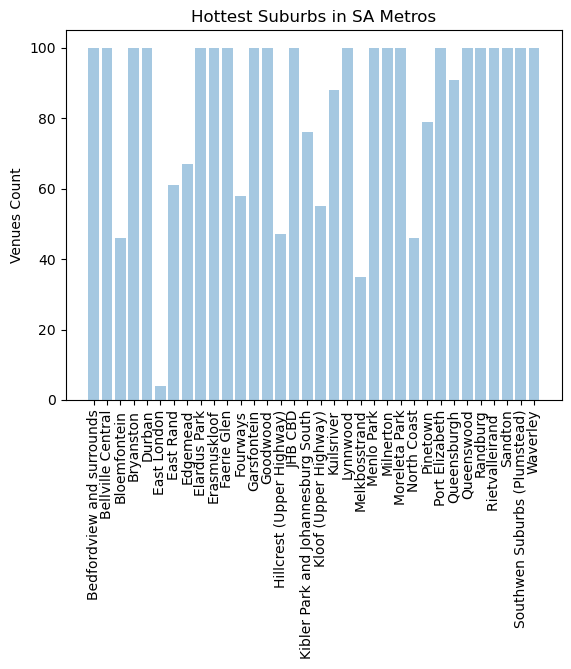

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

Venues_summary = SA_metros_venues.groupby('Suburbs').count().reset_index()
Venues_summary.drop(['Suburb Latitude','Suburb Longitude','Venue Latitude','Venue Longitude','Venue Category'],inplace = True,axis=1) 

objects = Venues_summary.Suburbs
y_pos = np.arange(len(objects))
performance = Venues_summary.Venue

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venues Count')
plt.title('Hottest Suburbs in SA Metros')
plt.xticks(rotation=90)

plt.show()

Here we can see that 21 out of 34 suburbs reached the 100 limit of foursquare API venues search. On the other hand, East London has the lowest venue count.

#### Lets find out how many unique categories can be curated from all the returned venues

In [12]:
print('There are {} uniques categories.'.format(len(SA_metros_venues['Venue Category'].unique())))

There are 170 uniques categories.


### Analyze Each Suburb

In [13]:
SA_metros_onehot = pd.get_dummies(SA_metros_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburbs column back to dataframe
SA_metros_onehot['Suburbs'] = SA_metros_venues['Suburbs']

# move neighborhood column to the first column
fixed_columns = [SA_metros_onehot.columns[-1]] + list(SA_metros_onehot.columns[:-1])
SA_metros_onehot = SA_metros_onehot[fixed_columns]

SA_metros_onehot.head()

,Suburbs,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,...,Toll Booth,Trail,Train Station,Turkish Restaurant,Video Store,Vineyard,Warehouse Store,Wine Bar,Winery,Zoo
0,East London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,East London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,East London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,East London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Goodwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping rows by suburbs and by taking the mean of the frequency of occurrence of each category

In [22]:
SA_metros_grouped = SA_metros_onehot.groupby('Suburbs').mean().reset_index()
SA_metros_grouped

,Suburbs,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,...,Toll Booth,Trail,Train Station,Turkish Restaurant,Video Store,Vineyard,Warehouse Store,Wine Bar,Winery,Zoo
0,Bedfordview and surrounds,0.010000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.01,0.010000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
1,Bellville Central,0.000000,0.01,0.01,0.000000,0.010000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.020000,0.000000
2,Bloemfontein,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.021739,...,0.000000,0.000000,0.000000,0.00,0.021739,0.000000,0.00,0.00,0.000000,0.000000
3,Bryanston,0.010000,0.00,0.00,0.000000,0.010000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.010000,0.000000,0.00,0.00,0.000000,0.010000
4,Durban,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.01,0.00,0.010000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
5,East London,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
6,East Rand,0.000000,0.00,0.00,0.000000,0.000000,0.016393,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
7,Edgemead,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.014925,0.00,0.00,0.000000,0.000000
8,Elardus Park,0.020000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.020000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000
9,Erasmuskloof,0.020000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,...,0.000000,0.020000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000


#### Confirming the new size

In [15]:
SA_metros_grouped.shape

(34, 171)

#### Printing each suburbs along with the top 5 most common venues

In [16]:
num_top_venues = 5

for burb in SA_metros_grouped['Suburbs']:
    print("----"+burb+"----")
    temp = SA_metros_grouped[SA_metros_grouped['Suburbs'] == burb].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bedfordview and surrounds----
           venue  freq
0           Café  0.08
1    Coffee Shop  0.06
2  Shopping Mall  0.06
3         Bakery  0.05
4     Steakhouse  0.05


----Bellville Central----
                  venue  freq
0  Fast Food Restaurant  0.11
1    Seafood Restaurant  0.07
2         Shopping Mall  0.06
3        Breakfast Spot  0.06
4            Steakhouse  0.06


----Bloemfontein----
                   venue  freq
0   Fast Food Restaurant  0.13
1         Breakfast Spot  0.13
2          Shopping Mall  0.07
3  Portuguese Restaurant  0.07
4             Steakhouse  0.07


----Bryanston----
                venue  freq
0               Hotel  0.08
1         Coffee Shop  0.07
2  Italian Restaurant  0.07
3         Golf Course  0.05
4          Steakhouse  0.05


----Durban----
                venue  freq
0                Café  0.10
1  Italian Restaurant  0.07
2   Indian Restaurant  0.06
3          Restaurant  0.06
4         Coffee Shop  0.06


----East London----
                

#### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each suburb.

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburbs']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburbs'] = SA_metros_grouped['Suburbs']

for ind in np.arange(SA_metros_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SA_metros_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head()

,Suburbs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bedfordview and surrounds,Café,Shopping Mall,Coffee Shop,Bakery,Steakhouse,Portuguese Restaurant,Restaurant,Supermarket,Pizza Place,Greek Restaurant
1,Bellville Central,Fast Food Restaurant,Seafood Restaurant,Steakhouse,Breakfast Spot,Shopping Mall,Coffee Shop,Portuguese Restaurant,Grocery Store,Chinese Restaurant,Café
2,Bloemfontein,Breakfast Spot,Fast Food Restaurant,Shopping Mall,Burger Joint,Portuguese Restaurant,Steakhouse,Seafood Restaurant,Restaurant,Coffee Shop,Italian Restaurant
3,Bryanston,Hotel,Coffee Shop,Italian Restaurant,Golf Course,Steakhouse,Pizza Place,Café,Shopping Mall,Seafood Restaurant,Indian Restaurant
4,Durban,Café,Italian Restaurant,Restaurant,Coffee Shop,Indian Restaurant,Portuguese Restaurant,Stadium,Steakhouse,Gastropub,Fast Food Restaurant


### Cluster Neighborhoods

K-Means algorithm is one of the most common cluster method of unsupervised learning. I will use K-Means algorithm for my study in this project.

First let's use the Elbow method to find the optimal k value.

In [68]:
# set number of clusters
n = 10

SA_metros_grouped_clustering = SA_metros_grouped.drop('Suburbs', 1)

# run k-means clustering
kmeans = KMeans(n_clusters= n, random_state=0).fit(SA_metros_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([3, 8, 8, 5, 0, 2, 6, 9, 3, 3, 3, 3, 3, 8, 7, 5, 8, 7, 8, 3, 4, 3,
       9, 3, 3, 7, 1, 7, 1, 3, 3, 5, 0, 1])

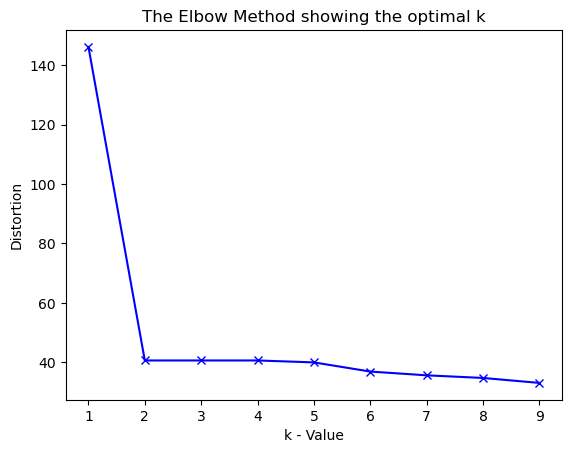

In [69]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(SA_metros_grouped_clustering)
    distortions.append(sum(np.min(cdist(SA_metros_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / SA_metros_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instaed of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - Value')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Then, let's run K-Means to cluster the suburbs into 2 clusters, since k=2 is the optimal K-value for the K-Means, see the graph above for demostration.

In [70]:
# set number of clusters
n = 2

SA_metros_grouped_clustering = SA_metros_grouped.drop('Suburbs', 1)

# run k-means clustering
kmeans = KMeans(n_clusters= n, random_state=0).fit(SA_metros_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each suburbs.

In [71]:
SA_suburbs_merged = suburbs

# add clustering labels
SA_suburbs_merged['Cluster Labels'] = kmeans.labels_

SA_suburbs_merged = SA_suburbs_merged.join(suburbs_venues_sorted.set_index('Suburbs'), on='Suburbs')

SA_suburbs_merged.head() # check the last columns!

,Metros,Suburbs,Average_Property_Value (Rand),Latitude,Longitude,Cluster Labels,HP_Level,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Buffalo City,East London,635983,-32.924593,27.644027,0,Low Level HP,Shopping Mall,Convenience Store,Fried Chicken Joint,Zoo,Donut Shop,Farmers Market,Farm,Event Space,Ethiopian Restaurant,Electronics Store
1,City of Cape Town,Goodwood,1694500,-33.905048,18.566278,0,Low Level HP,Steakhouse,Fast Food Restaurant,Coffee Shop,Breakfast Spot,Seafood Restaurant,Grocery Store,Portuguese Restaurant,Shopping Mall,Supermarket,Italian Restaurant
2,City of Cape Town,Edgemead,2344500,-33.871335,18.543579,0,Low Level HP,Steakhouse,Fast Food Restaurant,Grocery Store,Deli / Bodega,Coffee Shop,Café,Italian Restaurant,Breakfast Spot,Gym,Supermarket
3,City of Cape Town,Kuilsriver,1350000,-33.917228,18.687824,0,Low Level HP,Shopping Mall,Fast Food Restaurant,Steakhouse,Seafood Restaurant,Grocery Store,Winery,Restaurant,Coffee Shop,Breakfast Spot,Chinese Restaurant
4,City of Cape Town,Southwen Suburbs (Plumstead),2350000,-34.022901,18.475543,0,Low Level HP,Café,Vineyard,Restaurant,Pizza Place,Thai Restaurant,Sushi Restaurant,Coffee Shop,Trail,Steakhouse,Italian Restaurant


Let's estimate the number of 1st Most Common Venue in each cluster.Thus, we can create a bar chart which may help us to find proper label names for each cluster.

In [72]:
count_venue = SA_suburbs_merged
count_venue = count_venue.drop(['Metros','Suburbs','Average_Property_Value (Rand)', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Breakfast Spot,Café,Coffee Shop,Fast Food Restaurant,Golf Course,Hotel,Italian Restaurant,Seafood Restaurant,Shopping Mall,Steakhouse
0,1,10,1,8,1,3,1,2,3,3
1,0,0,0,1,0,0,0,0,0,0


Text(0, 0.5, 'Number of Venue')

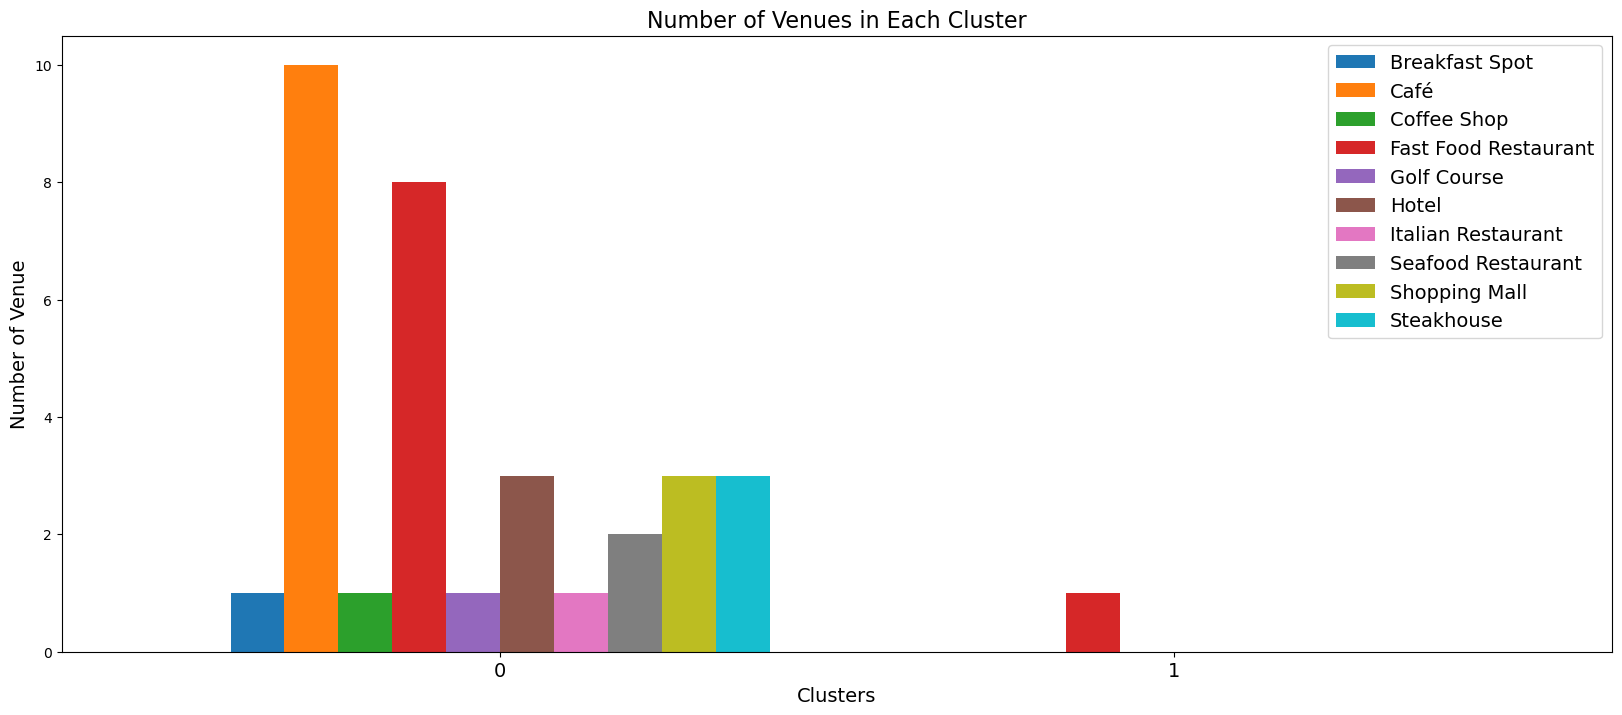

In [29]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Venue', fontsize=14)

When we examine above graph we can label each cluster as follows:

- Cluster 0 : "Multiple Social Venues"
- Cluster 1 : "Fast Food Restaurant Venues"

Also from these results, we can say these metros' suburbs are not very distict in terms of social life.

Now we will have to rank this suburbs based on their average housing prices from lowest to highest.

#### Let's combine average housing prices in the suburbs with the suburb's cluster label

In [73]:
Suburbs_Labels = suburbs.sort_values("Average_Property_Value (Rand)").reset_index(drop=True)
Suburbs_Labels = Suburbs_Labels.drop(['Latitude', 'Longitude'],axis = 1)
Suburbs_Labels

,Metros,Suburbs,Average_Property_Value (Rand),Cluster Labels,HP_Level
0,Mangaung Municipality,Bloemfontein,504794,0,Mid Level HP
1,Nelson Mandela Bay,Port Elizabeth,571635,0,Mid Level HP
2,Buffalo City,East London,635983,0,Low Level HP
3,City of eThekwini,Pinetown,750000,0,Low Level HP
4,Ekurhuleni,East Rand,789908,0,Low Level HP
5,City of eThekwini,Durban,920485,0,Low Level HP
6,City of Johannesburg,JHB CBD,1068215,0,Mid Level HP
7,City of eThekwini,Queensburgh,1300000,0,Low Level HP
8,City of eThekwini,Hillcrest (Upper Highway),1300000,0,Low Level HP
9,City of eThekwini,Kloof (Upper Highway),1300000,0,Low Level HP


Although there is huge similarities in terms of social values, We can see that the suburbs in SA's top four metropolitans are the ones with higher average property value for investment, City of Cape Town coming on top.

Let's categorize the average housing prices into 3 groups and then group the suburbs based on average housing price ranges

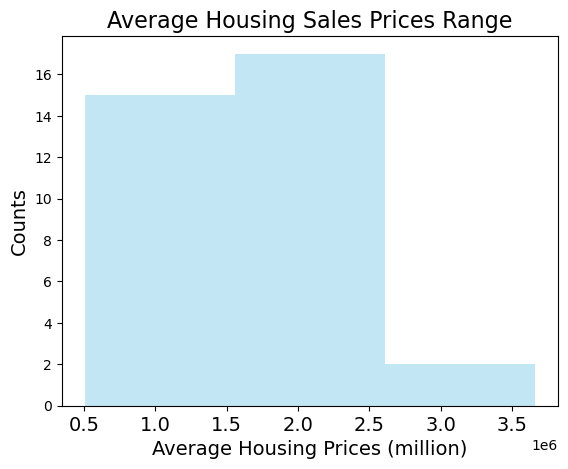

In [74]:
num_bins = 3
n, bins, patches = plt.hist(Suburbs_Labels['Average_Property_Value (Rand)'], num_bins, facecolor='skyblue', alpha=0.5)
plt.title("Average Housing Sales Prices Range",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Average Housing Prices (million)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

From the above histograme, we can define the ranges as below:
- R1.6mil and below AHP : "Low Level Housing"
- R1.6mil - R2.5 mil AHP : "Mid Level Housing"
- R2.5mil and above AHP:  "High Level Housing"

In this case, we can create **"HP_Level_labels"** with those levels.

In [76]:
HP_level = []
for i in range(0,len(Suburbs_Labels)):
    if (Suburbs_Labels['Average_Property_Value (Rand)'][i] < 1600000):
        HP_level.append("Low Level HP")
    elif (Suburbs_Labels['Average_Property_Value (Rand)'][i] > 1600000 and Suburbs_Labels['Average_Property_Value (Rand)'][i] < 2500000):
        HP_level.append("Mid Level HP")

    else:
        HP_level.append("High level HP")   

Suburbs_Labels['HP_Level'] = HP_level
Suburbs_Labels

,Metros,Suburbs,Average_Property_Value (Rand),Cluster Labels,HP_Level
0,Mangaung Municipality,Bloemfontein,504794,0,Low Level HP
1,Nelson Mandela Bay,Port Elizabeth,571635,0,Low Level HP
2,Buffalo City,East London,635983,0,Low Level HP
3,City of eThekwini,Pinetown,750000,0,Low Level HP
4,Ekurhuleni,East Rand,789908,0,Low Level HP
5,City of eThekwini,Durban,920485,0,Low Level HP
6,City of Johannesburg,JHB CBD,1068215,0,Low Level HP
7,City of eThekwini,Queensburgh,1300000,0,Low Level HP
8,City of eThekwini,Hillcrest (Upper Highway),1300000,0,Low Level HP
9,City of eThekwini,Kloof (Upper Highway),1300000,0,Low Level HP


Let's show the number of the **top 5 venues** information for each suburbs on the map. Thus, I grouped each suburbs by the number of top 5 venues and I combined those informations in "**Top_Venues_Count**" column.

In [77]:
top_venues= SA_metros_venues.groupby(['Suburbs','Venue Category']).size().reset_index(name='Counts')
top_venues = top_venues.sort_values(['Suburbs','Counts'],ascending=False).groupby('Suburbs').head(5).reset_index(drop=True)

top_venues['Top_Venues_Count'] = top_venues['Counts'].map(str) + " " + top_venues['Venue Category']
top_venues = top_venues.groupby(['Suburbs'])['Top_Venues_Count'].apply(", ".join).reset_index()

top_venues.head()

,Suburbs,Top_Venues_Count
0,Bedfordview and surrounds,"8 Café, 6 Coffee Shop, 6 Shopping Mall, 5 Bake..."
1,Bellville Central,"11 Fast Food Restaurant, 7 Seafood Restaurant,..."
2,Bloemfontein,"6 Breakfast Spot, 6 Fast Food Restaurant, 3 Bu..."
3,Bryanston,"8 Hotel, 7 Coffee Shop, 7 Italian Restaurant, ..."
4,Durban,"10 Café, 7 Italian Restaurant, 6 Coffee Shop, ..."


##  3. Results

let's merge all the new variables with related cluster information

Also, I will apply the function "cut" to determing the cluster name

In [86]:
results = Suburbs_Labels.join(top_venues.set_index('Suburbs'), on='Suburbs')

#Additing the suburbs' latitude and longitude into the final results dataframe
suburbs_lat_lon = suburbs.drop(['Metros', 'Average_Property_Value (Rand)'],axis = 1)
results = results.join(suburbs_lat_lon.set_index('Suburbs'), on='Suburbs')

#using the cut fuction to assign a cluste name
clusters = np.array([-0.5,0,1])
cluster_names = ['Multiple Social Venues','Fast Food Restaurant Venues']
results['Clusters_Name'] = pd.cut(results['Cluster Labels'],clusters,labels = cluster_names,include_lowest=False)

results

,Metros,Suburbs,Average_Property_Value (Rand),Cluster Labels,HP_Level,Top_Venues_Count,Latitude,Longitude,Clusters_Name
0,Mangaung Municipality,Bloemfontein,504794,0,Low Level HP,"6 Breakfast Spot, 6 Fast Food Restaurant, 3 Bu...",-29.111751,26.220795,Multiple Social Venues
1,Nelson Mandela Bay,Port Elizabeth,571635,0,Low Level HP,"12 Fast Food Restaurant, 8 Restaurant, 7 Hotel...",-33.941416,25.601705,Multiple Social Venues
2,Buffalo City,East London,635983,0,Low Level HP,"2 Shopping Mall, 1 Convenience Store, 1 Fried ...",-32.924593,27.644027,Multiple Social Venues
3,City of eThekwini,Pinetown,750000,0,Low Level HP,"10 Fast Food Restaurant, 8 Café, 8 Portuguese ...",-29.829241,30.839090,Multiple Social Venues
4,Ekurhuleni,East Rand,789908,0,Low Level HP,"8 Shopping Mall, 7 Fast Food Restaurant, 5 Por...",-26.152173,28.343029,Multiple Social Venues
5,City of eThekwini,Durban,920485,0,Low Level HP,"10 Café, 7 Italian Restaurant, 6 Coffee Shop, ...",-29.818580,31.020891,Multiple Social Venues
6,City of Johannesburg,JHB CBD,1068215,0,Low Level HP,"12 Coffee Shop, 5 Italian Restaurant, 4 Africa...",-26.201444,28.047020,Multiple Social Venues
7,City of eThekwini,Queensburgh,1300000,0,Low Level HP,"14 Fast Food Restaurant, 13 Portuguese Restaur...",-29.874975,30.907368,Multiple Social Venues
8,City of eThekwini,Hillcrest (Upper Highway),1300000,0,Low Level HP,"7 Fast Food Restaurant, 5 Café, 4 Portuguese R...",-29.784814,30.798573,Multiple Social Venues
9,City of eThekwini,Kloof (Upper Highway),1300000,0,Low Level HP,"8 Fast Food Restaurant, 7 Café, 4 Portuguese R...",-29.775055,30.831926,Multiple Social Venues


Finally, let's visualize the resulting clusters with its top 5 venues count

In [101]:
# create map
SA_SuburbsMap = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, metro,burb, cluster,cluster_name,top5_venues,HP_level, in zip(results['Latitude'], results['Longitude'],results['Metros'], results['Suburbs'], results['Cluster Labels'],results['Clusters_Name'],results['Top_Venues_Count'],results['HP_Level']):
    label = folium.Popup(str(metro) + ', '+str(burb) +', falls in cluster: ' +str(cluster)+",with "+str(cluster_name)+' as its cluster name. The suburbs top 5 venues count are ('+str(top5_venues)+") and this suburb falls in the "+str(HP_level)+' category range', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(SA_SuburbsMap)
       
SA_SuburbsMap

## 4. Discussion

As I mentioned before, South Afrinca has 8 metropolitans which host the hottest suburbs in the country. So, these suburbs differs when it comes to average property values but they have very similar social venues or activities. Thus, in this project I wanted to cluster the suburbs in these metros and map them based on the cluster they fall in and also include information like property pice/value class, top 5 social activities and other information about the suburb. The main objective was to see if the suburbs are similar based on the social activities and how does the property value/price compares.

I used the Kmeans algorithm as part of this clustering study. When I tested the Elbow method, I set the optimum k value to 2, meaning there were only two clusters in the dataset. However, only 32 suburbs were used, as classified as the hottest in South Africa when it comes to property investment. For more detailed and accurate guidance, the data set can be expanded and the details of the neighborhood or street can also be drilled.

I ended the study by visualizing the data and clustering information on the SA_SuburbsMap. In future studies, web or telephone applications can be carried out to direct investors.

## 5. Conclusion

It can be conculded that South African metros host most of the hottest cities and suburbs, which in turn attract alot of people to relocate to these areas. As a results, most SA's residents end up residing permanantely, buying properties and starting businesses in these cities and thus they become populated. 

It can be seen that these cities/suburbs are quite similar in terms of social venues/life, but they have distinct property values for investments.The suburbs with the hightest property values falls in the top three metro in South Africa, namely, City of Cape Town, City of Johannesburg and City of Tswane.

For this reason, SA residents and property investors can achieve better outcomes through their access to the platforms where the property values and social venues information is readily available for suburbs' comparison purposes before buying into.

Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platforms.

## 6. References:

* [1] [South Africa Goverment](https://www.gov.za/about-government/government-system/local-government)
* [2] [Gauteng hottest property investment](https://www.property24.com/articles/8-of-gautengs-hottest-property-investment-areas/28701)
* [3] [Property prices in Pretoria most in demand subsurbs](https://www.privateproperty.co.za/advice/news/articles/property-prices-in-pretorias-most-in-demand-suburbs/6502)
* [4] [Top 10 hotspots to live in the Western Cape](https://www.privateproperty.co.za/advice/news/articles/top-10-hotspots-to-live-in-the-western-cape/6878)
* [5] [KZN property hotspots](https://www.privateproperty.co.za/advice/news/articles/kzn-property-hotspots/7117)
* [6] [SOUTH AFRICA Housing Market Report](https://housingfinanceafrica.org/app/uploads/2021/03/Citymark-National-Property-Market-Report-3-March-2021-FINAL.pdf)
* [7] [Forsquare API](https://developer.foursquare.com/)
* [8] [Google Map](https://www.google.com/maps/)